### Author: Tanvi Bhagat

###  Implemented a Logistic Regression model to determine the causes for employee attrition, and predict when employees are going to leave a company, and assessed the performance of model.

### Part 1

In [1]:
#!pip install imblearn -U
#!pip install sklearn

### Importing Packages

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import pylab 
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score
from scipy import stats
from sklearn import datasets
from sklearn import linear_model
from sklearn.metrics import roc_auc_score,make_scorer,classification_report,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

from pylab import rcParams

rcParams['figure.figsize'] = (23, 8)
sns.set_style('whitegrid')
plt.style.use('seaborn-whitegrid')

### Acquiring Data and Performing Modifications

In [3]:
data_path="https://docs.google.com/spreadsheets/d/e/2PACX-1vQZvx0T8KIdTjHPYIfQxIjHS99EL5NFsWWnYw_zDbQ_sqSpdf7_txf36_aETKnWojgqbBd7A3sDketf/pub?gid=2043645550&single=true&output=csv"
ad= pd.read_csv(data_path)

In [4]:
ad.head(2)

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept,salary
0,0.82,0.97,3,244,5,0,0,0,SALES,MEDIUM
1,0.75,0.81,2,247,4,0,0,0,HR,SMALL


In [5]:
ad.tail(2)

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years,dept,salary
11247,0.98,0.67,4,209,6,0,0,0,MKT,SMALL
11248,0.75,0.69,3,242,3,0,0,0,SALES,LARGE


## Column List
#### employee_satisfaction - satisfaction of the employee between 0 to 1.
#### last_performance_rating - rating of the employee between 0 to 1
#### workload - range between 2 to 8
#### avg_montly_hours - The count of monthly average hours of each employee.
#### tenure_years - number of years the employee has been working in the company.
#### ergo_issues - binary values, 0= no issues, 1= employee has issues.
#### attrit - 1 if employee has left the company and 0 if not left the company.
#### promo_in_last_5_years - 1 for yes promotion and 0 for no promotion in the last 5 years
#### dept -  10 different departments 
#### salary - 3 categories i.e small, medium and large for salary of employee.

#### Checking for missing values

In [6]:
round(100*(ad.isnull().sum()/len(ad.index)), 2)

employee_satisfaction      0.0
last_performance_rating    0.0
workload                   0.0
avg_montly_hours           0.0
tenure_years               0.0
ergo_issues                0.0
attrit                     0.0
promo_in_last_5_years      0.0
dept                       0.0
salary                     0.0
dtype: float64

#### No Missing Values found in the data

In [7]:
list(ad)

['employee_satisfaction',
 'last_performance_rating',
 'workload',
 'avg_montly_hours',
 'tenure_years',
 'ergo_issues',
 'attrit',
 'promo_in_last_5_years',
 'dept',
 'salary']

In [8]:
Nunique = ad.nunique()
Nunique = Nunique.sort_values()
Nunique

ergo_issues                  2
attrit                       2
promo_in_last_5_years        2
salary                       3
workload                     6
tenure_years                 8
dept                        10
last_performance_rating     65
employee_satisfaction       92
avg_montly_hours           215
dtype: int64

### Describing Quantitative Variables

In [9]:
ad.describe()

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years
count,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000,11249.000000
mean,0.612957,0.716225,3.799716,201.176727,3.499600,0.144991,0.239577,0.021869
std,0.248235,0.171378,1.232190,50.058105,1.469892,0.352107,0.426844,0.146261
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,201.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


<ul>
<li>From the table above, it provides useful information:</li>
<li>Approximately 24% of the employees have left the firm, which is quite a huge loss to the company.</li>
<li>On an average the employees got a score of 0.71 which is quite good and the standard deviation is low. Even though the high evaluation score look good, the high attrition rate might imply that there may be other reasons that lead to the attrition of employee.</li>
<li>There are only few exployee got promotion and had work accident, they may not be the factors of employee attrition.</li>
<li>The satisfaction of employee is only 0.61, which is relatively low. We need to dig more into it to find out if there is relation with attrition.</li>
    </ul>

### Explore the data for only those who left the firm

In [10]:
attrit_df = ad[ad['attrit']==1]
attrit_df.describe()

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,attrit,promo_in_last_5_years
count,2695.000000,2695.000000,2695.000000,2695.000000,2695.000000,2695.000000,2695.0,2695.000000
mean,0.441080,0.719837,3.863451,208.086456,3.881633,0.048237,1.0,0.004082
std,0.264924,0.197608,1.812862,61.118062,0.976571,0.214307,0.0,0.063769
min,0.090000,0.450000,2.000000,126.000000,2.000000,0.000000,1.0,0.000000
25%,0.120000,0.520000,2.000000,147.000000,3.000000,0.000000,1.0,0.000000
50%,0.410000,0.790000,4.000000,226.000000,4.000000,0.000000,1.0,0.000000
75%,0.730000,0.900000,6.000000,262.000000,5.000000,0.000000,1.0,0.000000
max,0.920000,1.000000,7.000000,310.000000,6.000000,1.000000,1.0,1.000000


<ul>
<li>The table shows some information about the employees who left the company:</li>
<li>The employees who left the firm have performed marginally better than the average employee, which is quite weird we need more exploration.</li>
<li>These employees have a much less level of satisfaction.</li>
<li>Other factors seem quite balanced, these employees:</li>
<li>Spent almost the same amount of time each day in the office.</li>
<li>Were alloted equally as many projects as everyone else.</li>
<li>Spent almost the same years at the workplace as everyone else.</li>
<li>The propotion of work accident and promotion are still low, do not have big impact on attrition.</li>
    </ul>

In [14]:
print(ad.shape)
print(list(ad.columns))

(11249, 10)
['employee_satisfaction', 'last_performance_rating', 'workload', 'avg_montly_hours', 'tenure_years', 'ergo_issues', 'attrit', 'promo_in_last_5_years', 'dept', 'salary']


### Heat Map for all the variables

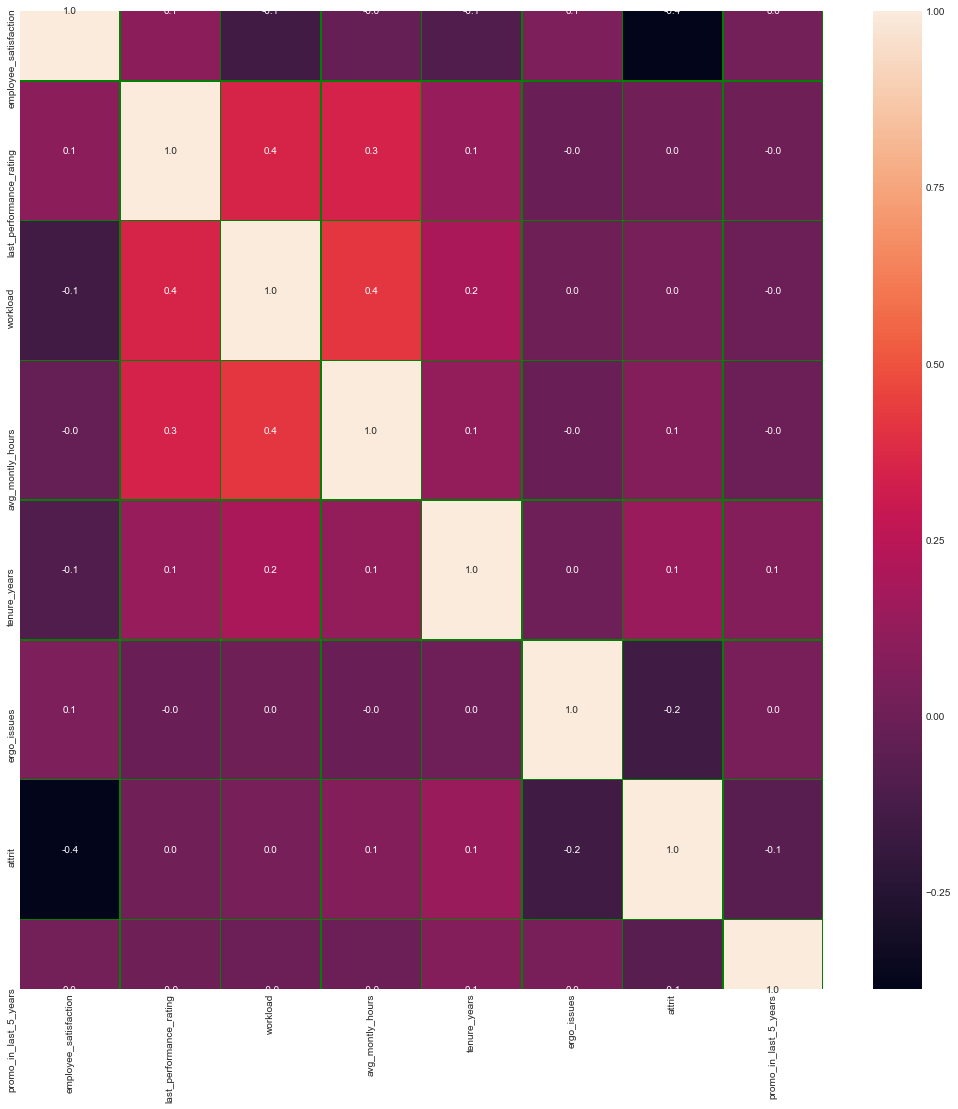

In [51]:
f,ax=plt.subplots(figsize=(18,18))
sns.heatmap(ad.corr(),annot=True,linewidths=0.5,linecolor="green",fmt=".1f",ax=ax)
plt.show()

<ul>
<li>From the heat map, we can find:</li>
<li>The workload and the average monthly hours worked by an employee and their last_perf are positively co-related.</li>
<li>The level of satisfaction and 'attrit' variables are negatively co-related which further leads evidence to our previous hypothesis.</li>
<li>Other than those none of the features show a co-relation high enough to mean something.</li>
    </ul>

### Plotting countplots for the categorical variables

### Explore the relation among attrit, salary and department

#### Find the propotion of attrition of different salary level

Text(0, 0.5, 'Salary Level')

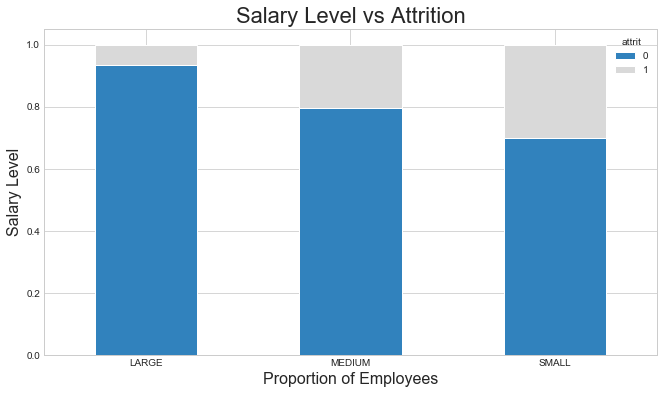

In [13]:
import pylab as pl
from matplotlib.ticker import PercentFormatter

table = pd.crosstab(ad.salary, ad.attrit)
table.div(table.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, colormap = 'tab20c', figsize=(11,6))
pl.xticks(rotation=360)
plt.title('Salary Level vs Attrition', fontsize=22)
plt.xlabel('Proportion of Employees', fontsize=16)
plt.ylabel('Salary Level', fontsize=16)

- The proportion of the employees attrition depend a great deal on their salary level; hence, salary level can be a good predictor in predicting the outcome.
- Small salary level employees have the highest probability to quit the job.

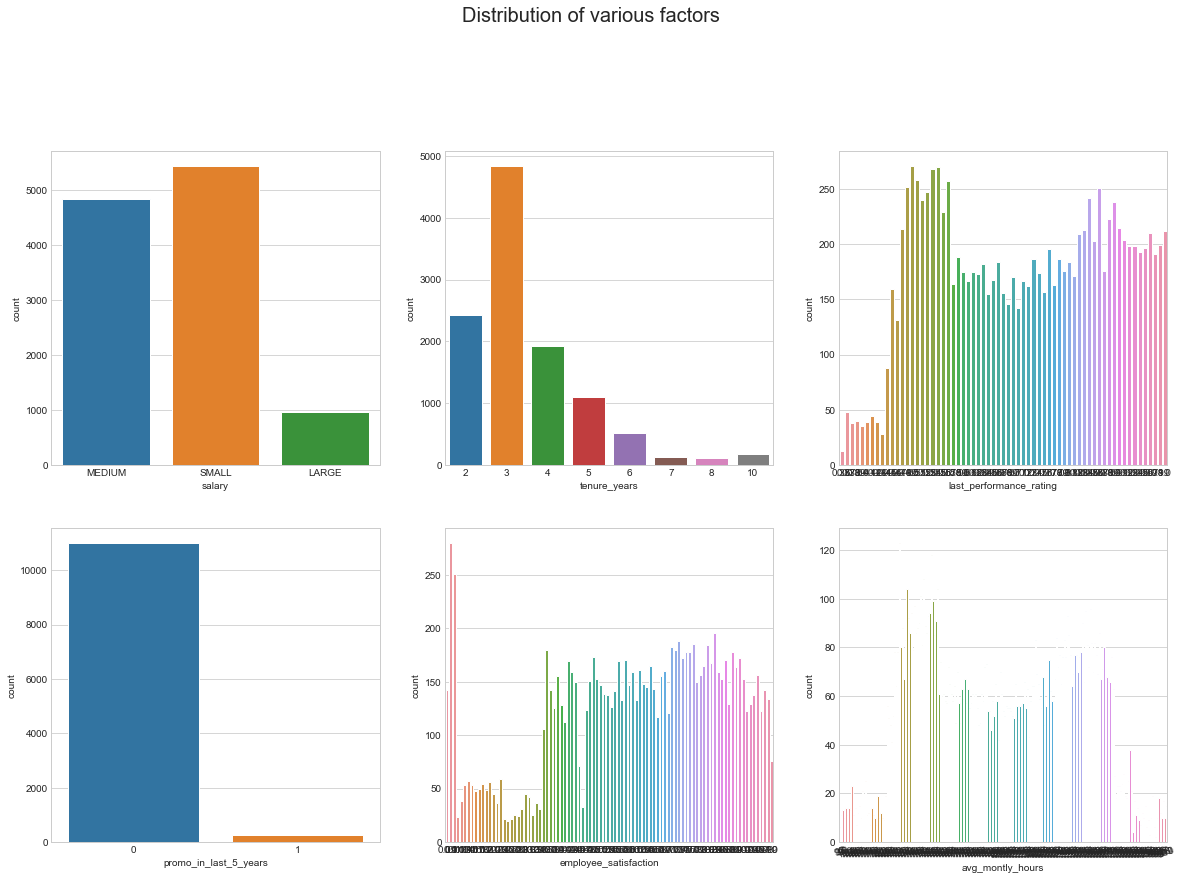

In [15]:
fig,ax = plt.subplots(2,3, figsize=(20,20))            
plt.suptitle("Distribution of various factors", fontsize=20)
sns.countplot(ad['salary'], ax = ax[0,0]) 
sns.countplot(ad['tenure_years'], ax = ax[0,1]) 
sns.countplot(ad['last_performance_rating'], ax = ax[0,2]) 
sns.countplot(ad['promo_in_last_5_years'], ax = ax[1,0])
sns.countplot(ad['employee_satisfaction'], ax = ax[1,1])  
sns.countplot(ad['avg_montly_hours'], ax = ax[1,2])  
plt.xticks(rotation=20)
plt.subplots_adjust(bottom=0.4)
plt.show()

In [16]:
ad.attrit.head(8)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
Name: attrit, dtype: int64

#### Note that the number of observations belonging to the '0' category is way greater than that belonging to '1' category. 

### Countplot to describe attrition:

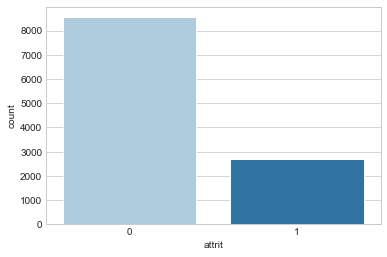

In [17]:
ad.attrit.value_counts()
sns.countplot(x = 'attrit', data = ad, palette = 'Paired')
plt.show()

In [18]:
AttritionRate=ad.attrit.value_counts()/len(ad)
AttritionRate

0    0.760423
1    0.239577
Name: attrit, dtype: float64

#### Looks like about 76% of employees stayed with the company and only 24% of employees left.

## Overview of summary (Attrition V.S. Non-Attrition)

In [52]:
Attrition_Summary = ad.groupby('attrit')
Attrition_Summary.mean()

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,promo_in_last_5_years
attrit,,,,,,,
0,0.667108,0.715087,3.779635,198.999766,3.379238,0.175473,0.027473
1,0.441080,0.719837,3.863451,208.086456,3.881633,0.048237,0.004082


## Department

### Find the frequency of attrition of department that employees work for

Text(0, 0.5, 'Frequency of Attrition')

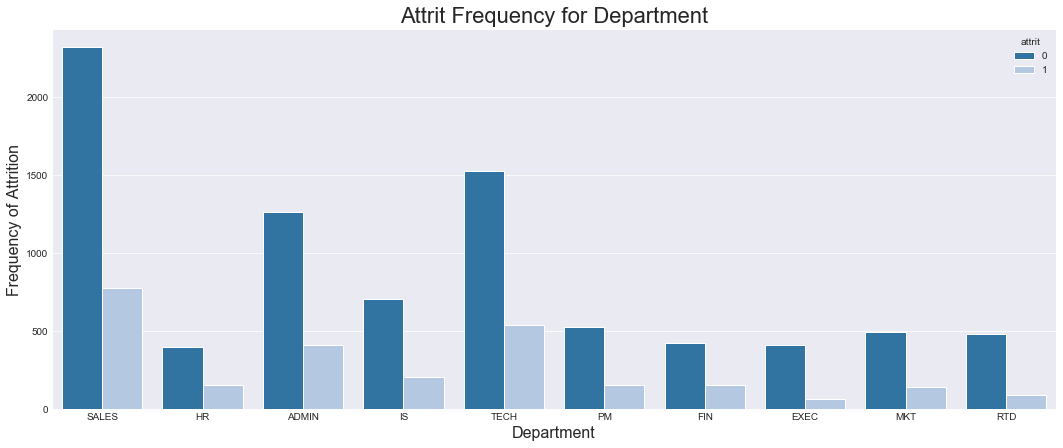

In [14]:
sns.set_style('darkgrid')
plt.figure(figsize=(18,7))
ax = sns.countplot(x = 'dept', hue = 'attrit', data = ad, palette = 'tab20')
ax.set_title('Attrit Frequency for Department', fontsize=22)
ax.set_xlabel('Department', fontsize=16)
ax.set_ylabel('Frequency of Attrition', fontsize=16)

- It is evident that the frequency of employees attrition depends a great deal on the department they work for. Thus, department can be a good predictor of the outcome variable.
- The sales department has seen the highest level of attrition.

### Department wise attrition 

In [27]:
pd.crosstab(columns=[ad.attrit],index=[ad.dept],margins=True,normalize='index') # set normalize=index to view rowwise %.

attrit,0,1
dept,,
ADMIN,0.753883,0.246117
EXEC,0.865263,0.134737
FIN,0.732297,0.267703
HR,0.722523,0.277477
IS,0.773875,0.226125
MKT,0.777080,0.222920
PM,0.772727,0.227273
RTD,0.842382,0.157618
SALES,0.749516,0.250484


#### From the above crosstab, we can see that about 75 % of the people in Administration department dont want to leave the organisation and only 24% want to leave. Similar conclusions can be drawn for other departments too from the above cross-tabulation.

In [54]:
ad.groupby(by= 'dept').sum()['attrit'].sort_values(ascending= False).head(25)

dept
SALES    776
TECH     541
ADMIN    412
IS       206
PM       155
FIN      155
HR       154
MKT      142
RTD       90
EXEC      64
Name: attrit, dtype: int64

#### 1. We can see that, Majority of the employees have left from the Sales Department followed by the TECH department. 
#### 2. EXEC has the less attrition rate.

### Average Monthly Hours

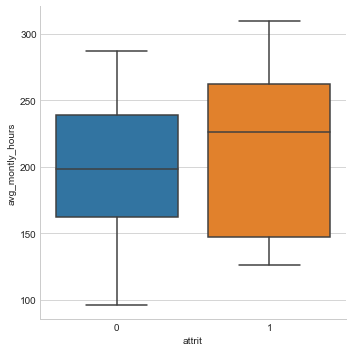

In [22]:
sns.factorplot(data=ad,y='avg_montly_hours',x='attrit',size=5,aspect=1,kind='box')

#### From above, note that the median as well the maximum average monthly hours of the peole with '1' attrition is higher than that of the '0' category. This shows that people with high average monthly hours have more tendency to leave the organisation which makes sense as they may be finding the working hours too much.

### Distribution of employee satisfaction

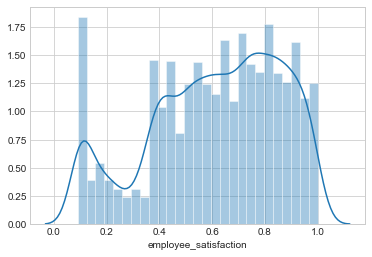

In [55]:
sns.distplot(ad['employee_satisfaction'])
plt.show() 

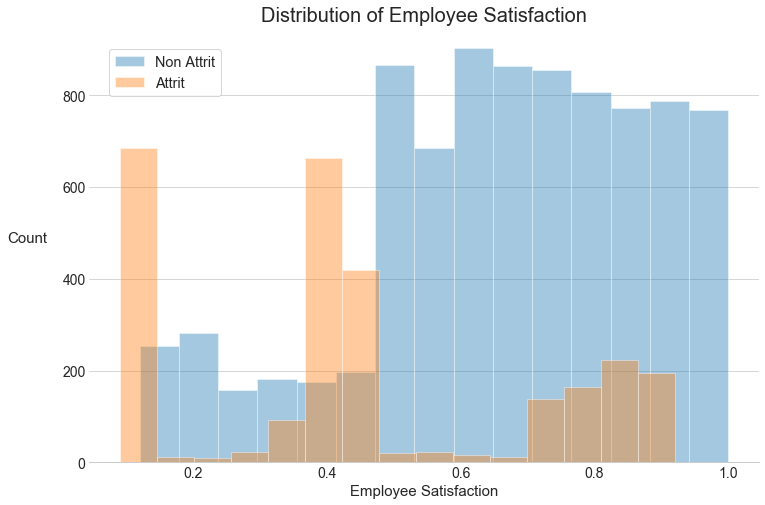

In [56]:
plt.figure(figsize=(12,8))
fig = sns.distplot(ad[ad['attrit'] == 0]['employee_satisfaction'], label='Non Attrit', kde=0, bins=15)
sns.distplot(ad[ad['attrit'] == 1]['employee_satisfaction'], label='Attrit', kde=0, bins=15)

sns.despine(left=1)

fig.grid(axis='x')

plt.xlabel('Employee Satisfaction',fontsize=15)
plt.ylabel('Count',fontsize=15, rotation=0)
fig.yaxis.labelpad = 30
plt.title('Distribution of Employee Satisfaction',fontsize=20);
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig.yaxis.labelpad = 35
plt.legend(fontsize='x-large', bbox_to_anchor=(0.03, 0.95), loc=2, borderaxespad=0., frameon=1)
plt.show()

#### From the above graph, we can see that attrition is present amongst all the employees with various employee satisfaction score. Highest being with very low employee satisfaction and we can see that there is no attrition amongst employees having the highest satisfaction.

### Countplot of 3 categories of Employee Salary

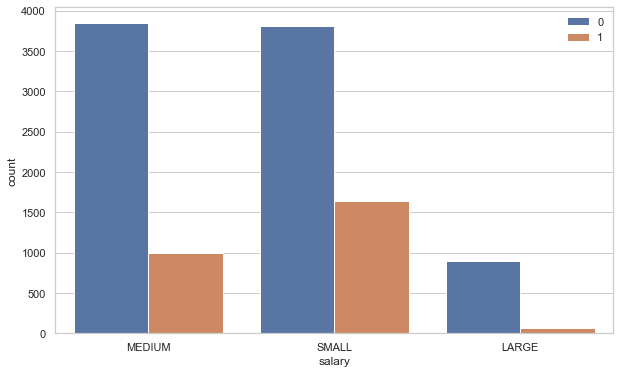

In [58]:
plt.figure(figsize=(10,6))
sns.countplot(data=ad, x='salary', hue='attrit')
plt.legend(bbox_to_anchor=(1, 1.0))

In [26]:
ad.salary.value_counts()

SMALL     5445
MEDIUM    4845
LARGE      959
Name: salary, dtype: int64

#### Majority of the employees come under the Small and Medium Salary category.

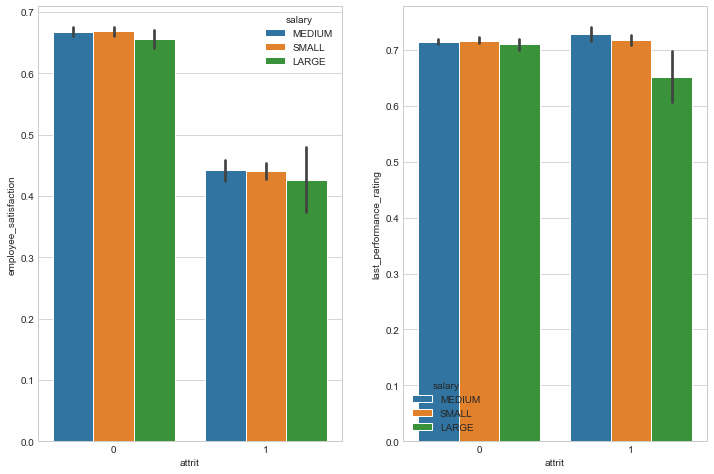

In [29]:
#on the basis of salary
columns = ["employee_satisfaction",
"last_performance_rating"]
plt.figure(figsize=(12,8))
j=0
for i in columns:
    j +=1
    plt.subplot(1,2,j)
    sns.barplot(x = 'attrit', y = ad[i], hue="salary", data =ad)

plt.show()

## Distplot of workload vs attrition

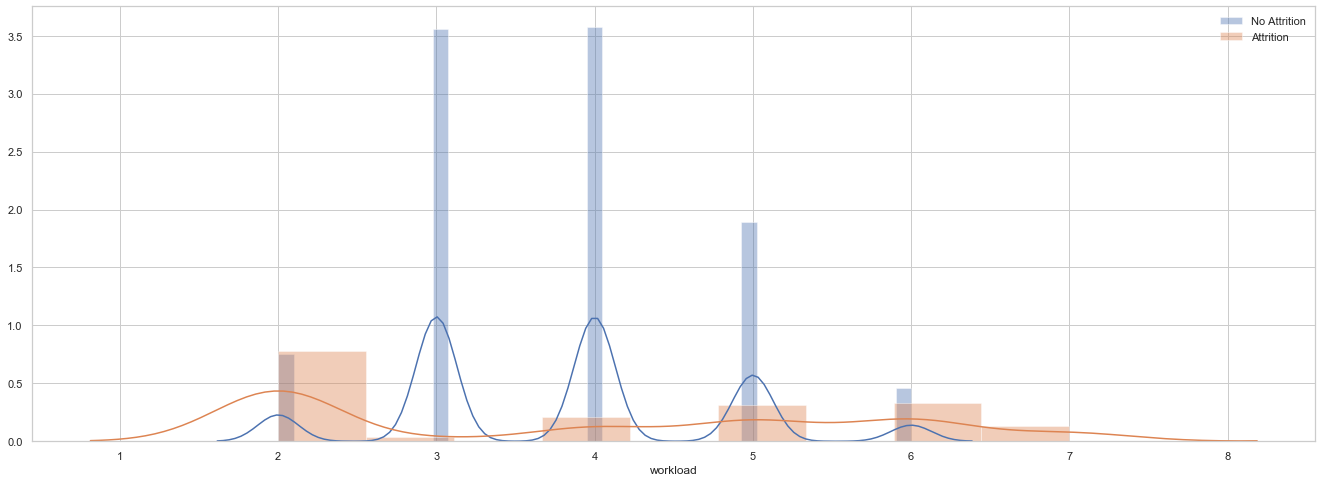

In [57]:
data0 = ad['workload'].loc[ad['attrit']==0]
data1 = ad['workload'].loc[ad['attrit']==1]

sns.set_style('whitegrid')
plt.figure(figsize=(23,8))
sns.set(style='whitegrid')
ax = sns.distplot(data0, hist=True)
ax = sns.distplot(data1, hist=True)
plt.legend(['No Attrition','Attrition'])

#### Attrition is present amongst employees having different workload parameters. Highest being  with employees with minimum workload. That is a bit strange and i feel there will be other factors along with workload to take under considerations for attrition.

## Logistic Regression

In [30]:
X =ad.iloc[:,ad.columns != 'attrit' ]
y =ad.attrit
X.head()

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,promo_in_last_5_years,dept,salary
0,0.82,0.97,3,244,5,0,0,SALES,MEDIUM
1,0.75,0.81,2,247,4,0,0,HR,SMALL
2,0.54,0.81,4,257,2,0,0,ADMIN,SMALL
3,0.60,0.65,4,160,2,0,0,IS,SMALL
4,0.85,0.92,4,151,3,1,0,IS,MEDIUM


### Label Encoding for department and salary column

In [60]:
encode= LabelEncoder()
X.loc[:, ['dept', 'salary']]= \
X.loc[:, ['dept', 'salary']].apply(encode.fit_transform)
X.head(5)



,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,promo_in_last_5_years,dept,salary
0,0.82,0.97,3,244,5,0,0,8,1
1,0.75,0.81,2,247,4,0,0,3,2
2,0.54,0.81,4,257,2,0,0,0,2
3,0.60,0.65,4,160,2,0,0,4,2
4,0.85,0.92,4,151,3,1,0,4,1


## SMOTE: Synthetic Minority Over-sampling Technique

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3)

In [33]:
smote = SMOTE(random_state=2)
X_train_res, y_train_res = smote.fit_sample(X_train, y_train.ravel())
X_test_res, y_test_res = smote.fit_sample(X_test,y_test)

In [34]:
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)

y_pred = logreg.predict(X_test_res)

### Calculating Accuracy

In [67]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test_res, y_test_res)))

Accuracy of logistic regression classifier on test set: 0.77


In [68]:
logreg.score(X_test_res, y_test_res)

0.7657153875819515

### Cross Validation Prediction and score

In [66]:
cv_pred = cross_val_predict(logreg,X_test_res,y_test_res,cv=5)
cv_score = cross_val_score(logreg,X_test_res,y_test_res,cv=5)
print('cross_val_score :',np.average(cv_score))

cross_val_score : 0.7659123044650438


### Confusion Matrix

In [65]:
cnf_matrix = metrics.confusion_matrix(y_test_res, y_pred)
cnf_matrix


array([[1888,  705],
       [ 510, 2083]])

<P>=>True Positive(TP)= 1888</P>
<P>=>True Negative(TN)= 2083</P>
<P>=>False Positive(FP)= 705</P>
<P>=>False Negative(NP)= 510</P>

Text(0.5, 257.44, 'Predicted label')

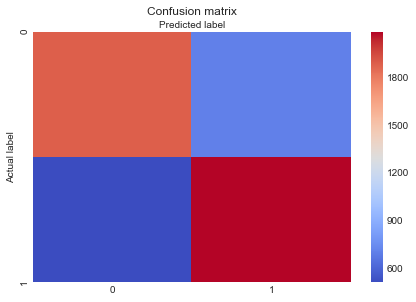

In [38]:
class_names=[1,2,3]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), cmap="coolwarm" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## ROC

ROC score is: 0.7657153875819513


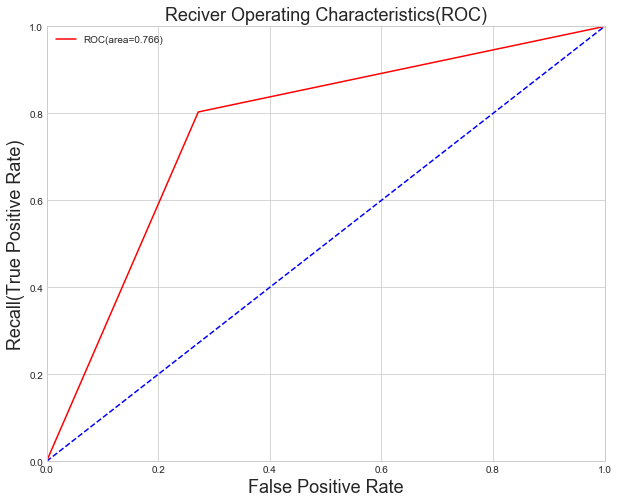

AUC: 0.7657153875819513


In [39]:
roc_score = roc_auc_score(y_test_res,y_pred)
print('ROC score is:',roc_score)
plt.figure(figsize=(10,8))
false_positive_rate, recall, thresholds = roc_curve(y_test_res,y_pred)

roc_auc = auc(false_positive_rate,recall)
plt.plot(false_positive_rate,recall,'r',label='ROC(area=%0.3f)' %roc_auc)

plt.legend()
plt.plot([0,1],[0,1],'b--')

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])

plt.title('Reciver Operating Characteristics(ROC)', fontsize=18)
plt.ylabel('Recall(True Positive Rate)', fontsize=18 )
plt.xlabel('False Positive Rate',fontsize=18)
plt.show()
print('AUC:',roc_auc)

In [41]:
logreg.predict(X_test_res)

array([1, 1, 1, ..., 1, 1, 1])

In [47]:
logreg.predict_proba(X_test_res)

array([[0.13166817, 0.86833183],
       [0.48603639, 0.51396361],
       [0.41023287, 0.58976713],
       ...,
       [0.4805651 , 0.5194349 ],
       [0.34106481, 0.65893519],
       [0.36560402, 0.63439598]])

In [48]:
prediction_df = pd.DataFrame(logreg.predict(X_test_res), columns = {'Prediction'}).set_index([pd.Index(X_test_res.index)])
probability_df = pd.DataFrame(logreg.predict_proba(X_test_res)).set_index([pd.Index(X_test_res.index)])
all_together_df = X_test_res.join(y_test_res).join(prediction_df).join(probability_df)
all_together_df

,employee_satisfaction,last_performance_rating,workload,avg_montly_hours,tenure_years,ergo_issues,promo_in_last_5_years,dept,salary,attrit,Prediction,0,1
0,0.160000,0.720000,3,203,3,0,0,8,1,0,1,0.131668,0.868332
1,0.890000,0.950000,2,181,5,0,0,9,1,1,1,0.486036,0.513964
2,0.370000,0.460000,2,149,3,0,0,5,0,1,1,0.410233,0.589767
3,0.780000,0.910000,3,238,2,0,0,7,0,0,0,0.807715,0.192285
4,0.830000,1.000000,5,240,5,0,0,0,2,1,0,0.554113,0.445887
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5181,0.895588,0.841081,5,264,4,0,0,9,1,1,0,0.812912,0.187088
5182,0.387441,0.491280,2,141,3,0,0,8,2,1,1,0.229530,0.770470
5183,0.836504,1.000000,4,217,5,0,0,9,2,1,1,0.480565,0.519435
5184,0.426643,0.506783,2,155,3,0,0,8,1,1,1,0.341065,0.658935


In [44]:
arbitrary_values1 = pd.DataFrame(data = {'employee_satisfaction':[0.90,0.50,0.75,0.89,0.09]})
arbitrary_values1.index

RangeIndex(start=0, stop=5, step=1)

In [49]:
arbitrary_values1 = pd.DataFrame(data = {'employee_satisfaction':[0.90,0.50,0.75,0.89,0.09]})
arbitrary_values2 = pd.DataFrame(data = {'workload': [1,3,6,7,6]})
arbitrary_values3 = pd.DataFrame(data = {'last_performance_rating':[0.74,0.72,0.9,1,0.46]})
arbitrary_values4 = pd.DataFrame(data = {'avg_montly_hours':[152,164,210,247,192]})
arbitrary_values5 = pd.DataFrame(data = {'tenure_years': [5,3,4,2,5]})
arbitrary_values6 = pd.DataFrame(data = {'ergo_issues':[0,1,1,1,0]})
arbitrary_values7 = pd.DataFrame(data = {'salary': [1,3,1,2,3]})
arbitrary_values8 = pd.DataFrame(data = {'dept':[1,2,3,5,8]})
arbitrary_values9 = pd.DataFrame(data = {'promo_in_last_5_years':[0,1,0,1,1]})

arbitrary_values_merged = arbitrary_values1.join(arbitrary_values2).join(arbitrary_values3).join(arbitrary_values4).join(arbitrary_values5).join(arbitrary_values6).join(arbitrary_values7).join(arbitrary_values8).join(arbitrary_values9).set_index([pd.Index(arbitrary_values1.index)])
arbitrary_values_merged

final_df = arbitrary_values_merged.join(pd.DataFrame(logreg.predict(arbitrary_values_merged), columns = {'Prediction'}).set_index([pd.Index(arbitrary_values_merged.index)]))
final_df

,employee_satisfaction,workload,last_performance_rating,avg_montly_hours,tenure_years,ergo_issues,salary,dept,promo_in_last_5_years,Prediction
0,0.90,1,0.74,152,5,0,1,1,0,0
1,0.50,3,0.72,164,3,1,3,2,1,0
2,0.75,6,0.90,210,4,1,1,3,0,1
3,0.89,7,1.00,247,2,1,2,5,1,1
4,0.09,6,0.46,192,5,0,3,8,1,1


## Observations:

- 1. The above table contains predicted attrition values for different features.
- 2. Employees with high satisfaction level are having high performance rating and are willing to stay in the company as they might be eligible for a promotion. Whereas we can see that the employees who have a lot of workload tend to leave the company.

### Things that the company can work on:

- If the company hope to retain employees, it needs to improve employee satisfactions. Maybe it can hold some campaigns to improve the relationship between company and employees, or properly assign the workload for everyone. Especially those who have high performance but low satisfaction, company must try to retain those talented employees!

- If possible, raise the salary for high performance employees is important. The higher the salary, the lower chance employees leave the job. From the analysis above, we found that employees with high performance still choose to leave the job because of small salary. If company really hope to retain high talented employees, it should raise the salary for them. All people need encouragement, sometimes give some benefit to employees they will feedback the company more than expected.